# Data Science Workshop
# NBA Free Throws Prediction

![title](img/free_throw_img.jpg)

In January 2015 a data-set of 600K NBA free-throws was upload to Kaggle by Sebastian-Mantey. The data was scraped from the website ESPN.com which belongs to an entertainment and sports programming network. 

Since the data-set was uploaded, 25 kernels were uploaded to Kaggle related to it. Most of the kernels summarize, analyze and visualize the data and do not try to predict anything. However, there are two interesting kernels:

The kernel ‘Shooting percentage over time’, engages with the questions How does the Free Throw shooting percent develop over time? Does it go down as the game approaches the ending due to higher pressure? Does it go up thanks to players being warmer, or alternatively - better shooters take the ball?

The findings of the analysis are that in the end of every quarter of a game, there is an increase in the number of free-throws and in the free-throws percentage. They also found that most of the throws in the end of every quarter were performed by better players, but still the absolute time of the throw affected the outcome more than how performed it. 

Another interesting kernel is ‘Pooling Partial Hierarchica via champs throw Free’, in which they try to find the best players in the data-set with statistical and probability methods such as complete pooling, and find the probability p for every player to succeed in the free-throw. 

Outside Kaggle, we found the article ‘Mindfulness and Free Throws’. This article investigate the relationship between mindfulness, preshot routine, and basketball free-throw percentage. The findings suggest that the combination of mindfulness levels, skill level (practice free-throw percentage), and competitive experience (year in school), all contribute to the prediction of competitive free throw percentage.


## Data preparation and cleaning


## Import Python Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from our_models import plot_confusion,logreg_grid_search
import seaborn as sns
import shap

%matplotlib inline


## Reading the Original Dataset


In [3]:
free_throws_db = pd.read_csv('free_throws.csv')
free_throws_db.drop_duplicates()
free_throws_db.head(10)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45
2,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18-Dec,2006 - 2007,1,7:26
3,106 - 114,PHX - LAL,261031013,1,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18-Dec,2006 - 2007,0,7:26
4,106 - 114,PHX - LAL,261031013,1,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21-Dec,2006 - 2007,1,7:18
5,106 - 114,PHX - LAL,261031013,1,Amare Stoudemire makes free throw 1 of 2,Amare Stoudemire,regular,33 - 20,2006 - 2007,1,3:15
6,106 - 114,PHX - LAL,261031013,1,Amare Stoudemire makes free throw 2 of 2,Amare Stoudemire,regular,34 - 20,2006 - 2007,1,3:15
7,106 - 114,PHX - LAL,261031013,2,Leandro Barbosa misses free throw 1 of 2,Leandro Barbosa,regular,43 - 29,2006 - 2007,0,10:52
8,106 - 114,PHX - LAL,261031013,2,Leandro Barbosa makes free throw 2 of 2,Leandro Barbosa,regular,44 - 29,2006 - 2007,1,10:52
9,106 - 114,PHX - LAL,261031013,2,Lamar Odom makes free throw 1 of 2,Lamar Odom,regular,44 - 30,2006 - 2007,1,10:37


Describition of dataset:
- end_result: host total score - guest total score
- game: host team vs guest team
- game_id: id of specific game
- period: which quarter
- play: who make free throw, make or miss free throw
- player: player name
- playoffs: whether a playoff game or regular game
- score: host team score - guest team score at that time
- season: NBA season
- shot_made: whether player got the free throw
- time: time left in that quarter

In [4]:
print("Number of free throws in database: %d"%(free_throws_db.shape[0]))
print("Number of games in database: {}".format(free_throws_db.game_id.unique().size))
print("Games distribution:")
free_throws_db['playoffs'].value_counts()

Number of free throws in database: 618019
Number of games in database: 12874
Games distribution:


regular     575893
playoffs     42126
Name: playoffs, dtype: int64

## Collecting more data from internet

In order to expand our dataset, we decided to use an open source python library PandasBasketball, and use a webscrapper in order to get more players stats from https://www.basketball-reference.com website

Example of basketball-reference NBA player stats webpage:
![title](img/lebron_page_1.jpg)
![title](img/lebron_page_2.jpg)

And our code to extract from website html our data

In [4]:
#from tools import get_player_stats
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, module='BeatifulSoup')
#dataFrame = get_player_stats("Lebron James")
#print(dataFrame.columns)
#dataFrame.head(20)

Columns used for this database for each player:
- Position : The most common position for the player over his seasons.
- FG%
- 3P%
- FT%
- Height
- Weight
- ShootingHand
- draftRank

## We merged both the datasets according our collected data from internet.
Some players stats had been inserted manually because some bugs found on PandasBasketball library

In [5]:
database_p1 = pd.read_csv("database_preprocessed_part1.csv")
database_p2 = pd.read_csv("database_preprocessed_part2.csv")
database = pd.concat([database_p1,database_p2])
database = database.drop(columns=['Unnamed: 0', 'Unnamed: 0'])
# Drop duplicated rows
database.drop_duplicates()
database.head(3)

,Unnamed: 0.1,end_result,game,game_id,period,play,player,playoffs,score,season,...,sec,abs_min,abs_time,scores,scoreDif,First_shot,Second_shot,Third_shot,First_shot_was_in,Second_shot_was_in
0,0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,0,0 - 1,2006 - 2007,...,45,1,15,"['0 ', ' 1']",1,1,0,0,0,0
1,1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,0,0 - 2,2006 - 2007,...,45,1,15,"['0 ', ' 2']",2,0,1,0,1,0
2,2,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,0,18-12,2006 - 2007,...,26,5,274,"['18', '12']",6,1,0,0,0,0


## PrePrecessing the data 


### Specifing Data Types

In [12]:
binary_variables = ['shot_made', 'playoffs', 'ShootingHand']
categorical_variables = ['end_result', 'game', 'game_id', 'period', 'play', 'player', 'season','First_shot',
                        'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']
numeric_variables = ['score','time','FG%','2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank', 'Pos']

In [13]:
database.count()

Unnamed: 0.1          617786
end_result            617786
game                  617786
game_id               617786
period                617786
play                  617786
player                617786
playoffs              617786
score                 617786
season                617786
shot_made             617786
time                  617786
FG%                   617786
2P%                   617786
3P%                   612884
FT%                   570699
Height                617786
Weight                617786
draftRank             617786
Pos                   617786
ShootingHand          617786
Team                  617786
Difference            617786
minute                617786
sec                   617786
abs_min               617786
abs_time              617786
scores                617786
scoreDif              617786
First_shot            617786
Second_shot           617786
Third_shot            617786
First_shot_was_in     617786
Second_shot_was_in    617786
dtype: int64

We can see, we have only two columns with missing data. First - the draftRank column. 
This values are missing because the players performed the free throw didn't have a draft rank and not because we couldn't collect the data. Second - 3P% has missing values since there are players that have never throws a 3-pointer.

### processing the columns 
We will change the relevant categorical variable (only the position) to numeric and change the binary and numeric variables to be in the appropriate type.

In [8]:
# adding an abs_time column to our database:
database['minute'] = database.time.apply(lambda x: int(x[:len(x)-3]))
database['sec'] = database.time.apply(lambda x: int(x[len(x)-2:]))
database['abs_min'] = 12 - database['minute']+12*(database.period -1)
database['abs_time'] = 60*(database.abs_min-1) + 60 - database['sec']

# adding a scoreDif column that represents the difference in the groups scores in the time of the throw:
database['scores'] = database.score.replace(' - ', '-').apply(lambda x: x.split('-'))
database['scoreDif'] = database.scores.apply(lambda x: abs(int(x[1])-int(x[0])))

database.dtypes

end_result       object
game             object
game_id           int64
period            int64
play             object
player           object
playoffs         object
score            object
season           object
shot_made         int64
time             object
FG%             float64
2P%             float64
3P%             float64
FT%             float64
Height           object
Weight           object
draftRank        object
Pos              object
ShootingHand     object
Team             object
Difference      float64
minute            int64
sec               int64
abs_min           int64
abs_time          int64
scores           object
scoreDif          int64
dtype: object

## Analyzing the data 


### Analyzing the number of throws troughout the game

We would like to show the free throws distribution throughout the game time,
in our current dataset, the time column represents the time left in that quarter and the period column represents the quarter of the game, so we'll add a new column to our data which calculate the absolute time in the game that the throw was made.

In [9]:
#  counting the num of throws, and success throws precentage per minute
minutes = range(int(max(database.abs_min)))
total_throws = []
success_throws = []
success_precentage = []

def count_throws(database,minute):    
    made = len(database[(database.abs_min == minute) & (database.shot_made == 1)])
    success_throws.append(made)
    total = len(database[database.abs_min == minute])
    total_throws.append(total)
    if total == 0:
        precentage = 0.0
    else:
        precentage = made/total
    success_precentage.append(precentage)

for minute in minutes:
    count_throws(database,minute)

Text(0, 0.5, 'num of throws')

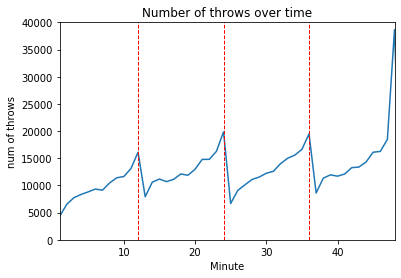

In [10]:
# Number of throws over time
plt.plot(minutes,total_throws)
plt.title('Number of throws over time')
plt.xlim([1,48])
plt.ylim([0, 40000])
plt.plot([12,12],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,40000], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('num of throws')

Text(0, 0.5, 'Free Throws %')

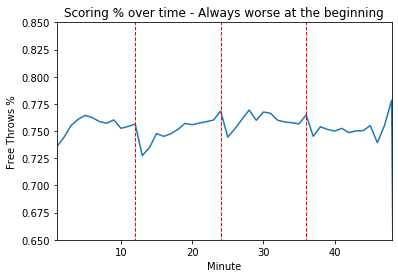

In [11]:
# Success throws precentage over time   
plt.plot(minutes,success_precentage)
plt.title('Scoring % over time - Always worse at the beginning')
plt.xlim([1,48])
plt.ylim([0.65,0.85])
plt.plot([12,12],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,1], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('Free Throws %')

From the plots we can observe that at the begining of every querter, both the number of free throws and the success precentage drops.
Moreover, at the end of a quarter, and especially at the end of the game, both plots increase.
We can explain this behaivor, as basketball rules when a team made more than 5 fouls, every another foul made in that quarter will be penalty with a free throw.


### Analyzing the number of throws troughout the game
We want to see how the average of free throws attempted and succeed in games over our differents season in our dataset are distributed.

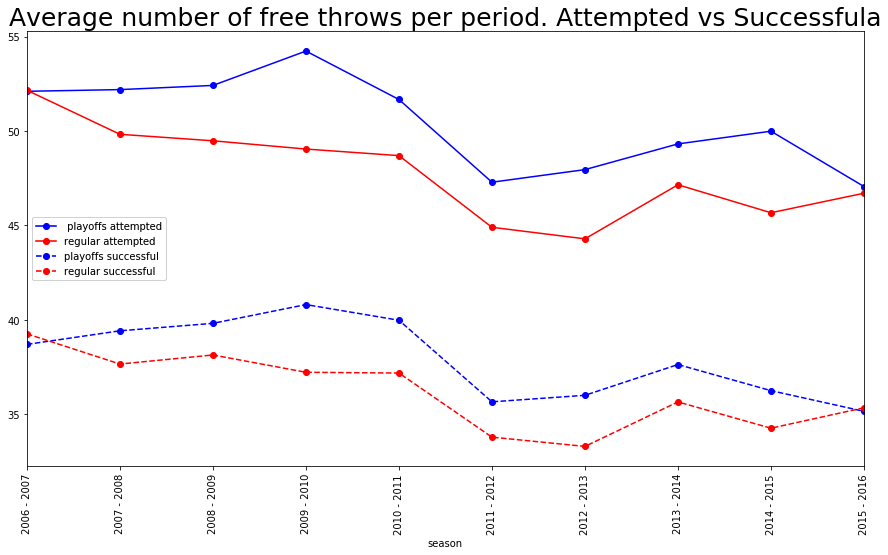

In [12]:
shot_attempted_per_game = database.groupby(["season", "playoffs"])['shot_made'].count().unstack()
shot_made_per_game = database.groupby(["season", "playoffs"])['shot_made'].sum().unstack()

# this has to be divided by the number of games for each season to get an average
number_of_games=database.groupby(["season", "playoffs"])['game_id'].nunique().unstack()

average_shot_made_per_game = shot_made_per_game/number_of_games
average_shot_attempted_per_game = shot_attempted_per_game/number_of_games


f, (ax1) = plt.subplots(figsize=(18,18))
first=average_shot_attempted_per_game.plot(ax=ax1, marker='o', figsize=(15,8), xticks=range(10), color=['b','r'], rot=90)
second=average_shot_made_per_game.plot(ax=ax1, marker='o', linestyle='--', figsize=(15,8), xticks=range(10), color=['b','r'], rot=90)
ax1.set_title('Average number of free throws per period. Attempted vs Successfula', size=25)
legend=plt.legend((' playoffs attempted','regular attempted','playoffs successful','regular successful'), loc=6)
ax1.add_artist(legend)
plt.show()

We can see that are not very big differences over the seasons at both attempted and successful shots.
But there is a clear difference between the amount of made shots and and successful shots at playoffs and regular season.


In [13]:
made_shot_perc , missed_shot_perc = database['shot_made'].value_counts(normalize=True) * 100
print("Made shots percentage in dataset: %.2f"%(made_shot_perc))
print("Missed shots percentage in dataset: %.2f"%(missed_shot_perc))


Made shots percentage in dataset: 75.68
Missed shots percentage in dataset: 24.32


### The correlation between the player's draft rank and the free-throw result

We wanted to check if there is a conection between the draft rank of the player performing the shot and the result of the shot. 
We have some missing values in the draftRank column, and it was because the player throwing had no draft rank, so we will fill the NAN cells with 61.

In [14]:
# Function that replace the field "undrafted" with a 0 in draftRank column

database['draftRank'] = database['draftRank'].replace(np.nan, 61)
database['draftRank'] = database['draftRank'].replace("undrafted", 61)
# pd.to_numeric(free_throws_db['draftRank'])
database['draftRank'] = database.draftRank.apply(lambda x: int(float(x)))

np.nanmax(database['draftRank'])

ranks = range(1, int(np.nanmax(database['draftRank']))+1)
success_precentage_by_rank = []

def throws_per_rank(database,rank):    
    total = len(database[database.draftRank == rank])
    if total == 0:
        precentage = 0.0
    else:
        made = len(database[(database.draftRank == rank) & (database.shot_made == 1)])
        precentage = made/total
    success_precentage_by_rank.append(precentage)

for rank in ranks:
    throws_per_rank(database,rank)

Text(0, 0.5, 'Free Throws %')

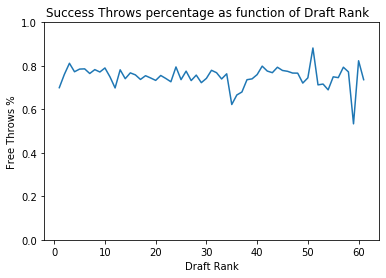

In [15]:
# Success throws precentage over time
plt.plot(list(ranks),success_precentage_by_rank)
plt.title('Success Throws percentage as function of Draft Rank  ')
plt.ylim([0,1])
plt.xlabel('Draft Rank')
plt.ylabel('Free Throws %')

As we see, there is no special trend in the graph (the FT% is between 0.7 to 0.9 for all ranks). We expected that the higher-ranked players would have better performence but we can't conclude it from the data. 

We have to take under consideration that the draft-rank data is not uniformly distributed, as we can see in the graph below, and is biased towared small values (the value 0 represents missing values, and in our case players who had no draft rank), so the barplot above needs to be normalized.

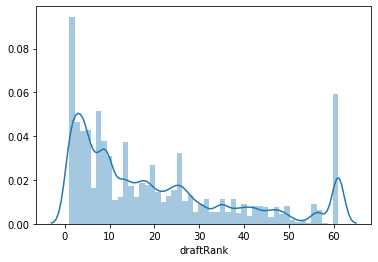

In [16]:
sns.distplot(database['draftRank'])

### The correlation between the score difference and the free-throw result

We will add a column calculating the differance.
We assume that if the difference is small in the time of the shot, the player would be more stressed and his shooting precentage would drop. 

In [17]:
difs = range(int(np.min(database['scoreDif']))+1,int(np.max(database['scoreDif']))+1)
success_precentage_by_scoreDif = []

def throws_per_dif(database,dif):    
    total = len(database[database.scoreDif == dif])
    if total == 0:
        precentage = 0.0
    else:
        made = len(database[(database.scoreDif == dif) & (database.shot_made == 1)])
        precentage = made/total
    success_precentage_by_scoreDif.append(precentage)

for dif in difs:
    throws_per_dif(database,dif)

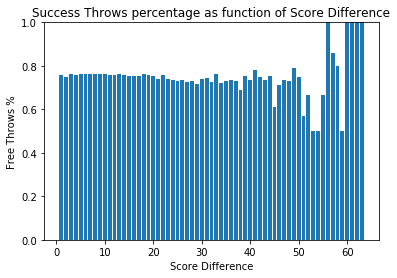

(0, 15)

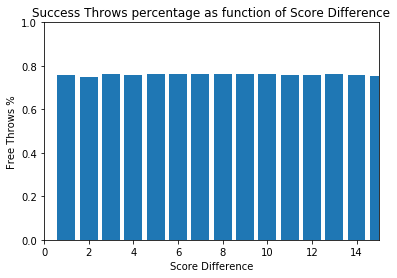

In [18]:
# Success throws precentage over time
plt.bar(list(difs),success_precentage_by_scoreDif)
plt.title('Success Throws percentage as function of Score Difference')
plt.ylim([0,1])
plt.xlabel('Score Difference')
plt.ylabel('Free Throws %')
plt.show()
plt.bar(list(difs),success_precentage_by_scoreDif)
plt.title('Success Throws percentage as function of Score Difference')
plt.ylim([0,1])
plt.xlabel('Score Difference')
plt.ylabel('Free Throws %')
plt.xlim(0,15)

At the 'Success Throws percentage as function of Score Difference' plot, it seems that our hypotesis that as long as the score difference gets bigger, so as the free-throw success precentaege is partly true. 
We can see a trend in the graph but it is not continuous.

### The correlation between the player position and the free-throw result
We want to analyze if the "Position" feature of each player could be a helpful feature that may help our prediction model.
Above we can see a plot showing the distribution of the FT% over the different positions.

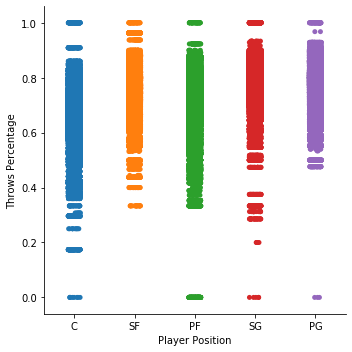

In [19]:
ax2 = sns.catplot(x="Pos", y="FT%", data=database);
#ax2 = sns.catplot(x="Pos", y="FT%",  kind="swarm", data=database);
ax2.set(xlabel='Player Position', ylabel='Throws Percentage')
plt.show()

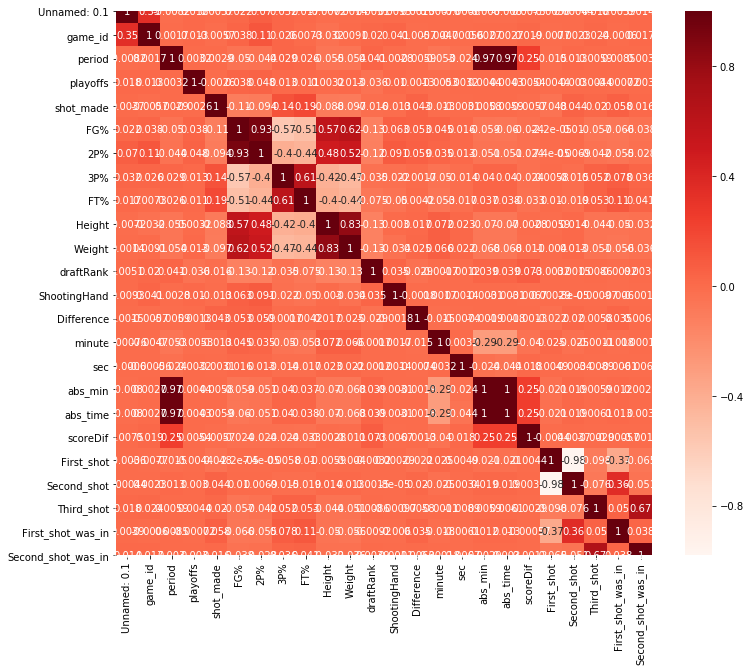

In [14]:
# Find correlation between all variables
from preProcess import find_correlations
find_correlations(database)

Average FT% at each position

In [21]:
database.groupby('Pos').agg({'FT%':'mean'})

,FT%
Pos,
C,0.664836
PF,0.720946
PG,0.795977
SF,0.770927
SG,0.795559


We can see that Centers players owns the worst percentage.

Point Guards and Shouting Guards players holds the best percentage over all the positions.

Next, we will check how well our dataset represents the general population of NBA Players.
1. MSE of the FT% players achieved in their carrers and their FT% we have in the dataset.

### Our goal
We’ll try to explore two options for prediction:

•	Offline prediction: try to predict the players succes percentage (for all kinds of throws) for the current season based on his past performance and give the coach an insight about the player. 

•	Online prediction : try to predict whether a player will hit in a certain throw. 

### What's next?

- Extract more statistical analysis on our current data, find corralation between more than two parameters. 
- Pre-process our data in order to create an initial ML model.
- Achieve good results on our ML model
- Try to reduce our problem dimension/features by analyzing which features have big influence.
- "Engineer" more strong features in order to achieve dimension reduction.
- Build new ML model and achieve good results, again! YEY!
- Explain our ML model results, when it fails and why

 ### Fitting a model
 
 We will choose the relevant columns (ommiting most of the categorical variables) from our model_database

In [22]:
# changing the position variable from categorial variable to numeric variable:
from preProcess import preProcess_position
database = preProcess_position(database)

# changing the playoff and ShootingHand to binary variables:
database['playoffs'] = database['playoffs'].map(lambda x : 0 if x == 'regular' else 1)
database['ShootingHand'] = database['ShootingHand'].map(lambda x : 0 if x == 'Right' else 1)

# modify the numeric variables Height and Weight:
database['Height'] = database['Height'].map(lambda x : int(x))
database['Weight'] = database['Weight'].map(lambda x : int(x))

# as we saw earlier, we have missing data in the 'FT%' and the '3P%' columns so we will fill the NA cells with the mode of the column
database['FT%'] = database['FT%'].fillna(database['FT%'].mode()[0])
database['3P%'] = database['3P%'].fillna(database['FT%'].mode()[0])

## Done pre-processing the data for now.
### Starting to prepare data for models

In [15]:
database_p1 = pd.read_csv("database_preprocessed_part1.csv")
database_p2 = pd.read_csv("database_preprocessed_part2.csv")
database = pd.concat([database_p1,database_p2])
database = database.drop(columns=['Unnamed: 0', 'Unnamed: 0'])
database = database.dropna()

print(database.shape)
counts = database.shot_made.value_counts()
print(f"Shots made are {counts[1]/database.shape[0]:.2f} % of dataset")
print(f"Shots missed are {counts[0]/database.shape[0]:.2f} % of dataset")


(567263, 34)
Shots made are 0.76 % of dataset
Shots missed are 0.24 % of dataset


#### Choosing our model's parameters from dataset

In [19]:
# we choose the relevant variables for our model:
continuous_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank','abs_min', 'Difference']
binary_parameters = ['playoffs', 'Pos', 'ShootingHand','First_shot',
                        'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in'] 
binary_database = pd.DataFrame(database[binary_parameters])
database[continuous_parameters].describe()

,FG%,2P%,3P%,FT%,Height,Weight,draftRank,abs_min,Difference
count,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000
mean,0.464319,0.489615,0.294291,0.749806,200.642212,101.117845,19.469024,27.732487,0.625861
std,0.046051,0.038692,0.113909,0.091865,9.112468,12.559274,17.656197,14.120636,10.493966
min,0.136000,0.188000,0.000000,0.000000,165.000000,61.000000,1.000000,1.000000,-63.000000
25%,0.434000,0.466000,0.275000,0.708520,193.000000,92.000000,5.000000,16.000000,-6.000000
50%,0.453000,0.482000,0.335000,0.768688,201.000000,100.000000,14.000000,28.000000,1.000000
75%,0.493000,0.509000,0.366000,0.808055,208.000000,111.000000,28.000000,40.000000,7.000000
max,0.669000,0.681000,1.000000,1.000000,229.000000,147.000000,61.000000,96.000000,59.000000


For our model, we assume that our variables are normally distributed.
We will examine this hypothesis and normalize the variables

We'll plot the distribution plot of the variables 'FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference'
(in 3 different plots because of the scale diffrence) :

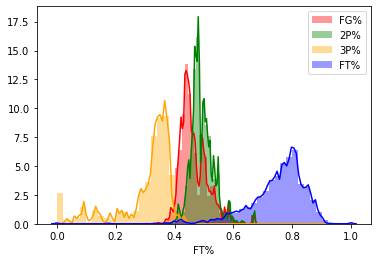

In [25]:
sns.distplot(database['FG%'], color = 'red', label = "FG%") 
sns.distplot(database['2P%'], color = 'green', label = "2P%") 
sns.distplot(database['3P%'], color = 'orange', label = "3P%") 
sns.distplot(database['FT%'], color = 'blue', label = "FT%") 
plt.legend()

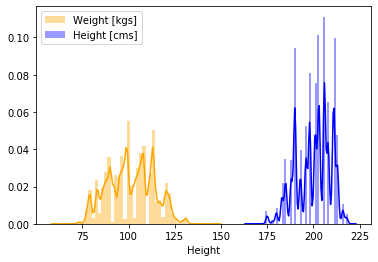

In [26]:
sns.distplot(database['Weight'], color = 'orange', label = "Weight [kgs]") 
sns.distplot(database['Height'], color = 'blue', label = "Height [cms]")
plt.legend()

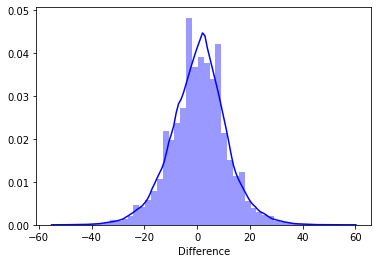

In [27]:
sns.distplot(database['Difference'], color = 'blue') 

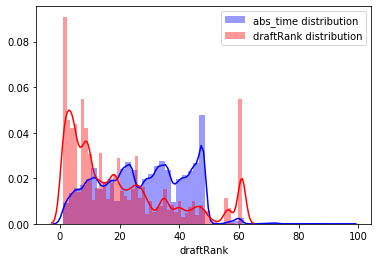

In [28]:
sns.distplot(database['abs_min'], color = 'blue', label = 'abs_min distribution') 
sns.distplot(database['draftRank'], color = 'red', label = 'draftRank distribution') 
plt.legend(labels=['abs_time distribution','draftRank distribution'])
plt.show()

### Splitting dataset to test-train to avoid data-leak

In [26]:
## SPLITTING DATASET TO TRAIN AND TEST
from sklearn.model_selection import train_test_split

v = database.player.value_counts()
database = database[database.player.isin(v.index[v.gt(200)])] ## leave only players with more than 200 games.

model_parameters = ['player','playoffs', 'Pos', 'ShootingHand', 'FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight',
                    'draftRank','abs_min', 'Difference','shot_made','First_shot',
                    'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']
model_database = database[model_parameters]
model_database.describe()

# Keep small database with original FT%
db_for_baseline_model = model_database[["FT%","shot_made"]]


Y = model_database['shot_made']
X = model_database.drop(columns=['shot_made','player'])

X_raw_train, X_raw_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

train_counts = y_train.value_counts()
print(f"Shots made are {train_counts[1]/y_train.shape[0]:.2f} % of train dataset")
print(f"Shots missed are {train_counts[0]/y_train.shape[0]:.2f} % of train dataset")
print("--------------------------------------")
test_counts = y_test.value_counts()
print(f"Shots made are {test_counts[1]/y_test.shape[0]:.2f} % of test dataset")
print(f"Shots missed are {test_counts[0]/y_test.shape[0]:.2f} % of test dataset")

Shots made are 0.76 % of train dataset
Shots missed are 0.24 % of train dataset
--------------------------------------
Shots made are 0.76 % of test dataset
Shots missed are 0.24 % of test dataset


We can see most of the variables are distribute with a gaussian shape.
So at different models we will try different methods for normalization or standartization of the features.

Example of standartization and normalization of features:

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
example = X_raw_train.copy()
example[semiNormal_parameters] = sc.fit_transform(example[semiNormal_parameters])

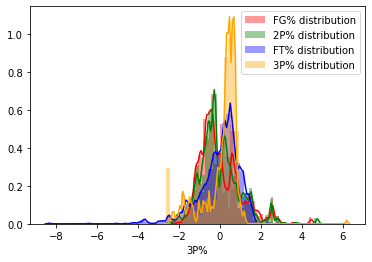

In [22]:
sns.distplot(example['FG%'], color = 'red') 
sns.distplot(example['2P%'], color = 'green') 
sns.distplot(example['FT%'], color = 'blue') 
sns.distplot(example['3P%'], color = 'orange') 
plt.legend(labels=['FG% distribution', '2P% distribution', 'FT% distribution', '3P% distribution'])
plt.show()

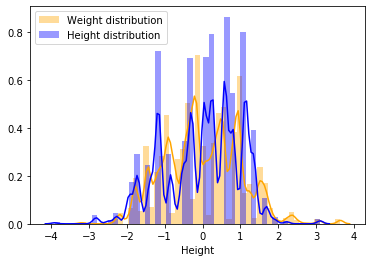

In [23]:
sns.distplot(example['Weight'], color = 'orange') 
sns.distplot(example['Height'], color = 'blue') 
plt.legend(labels=['Weight distribution', 'Height distribution'])
plt.show()

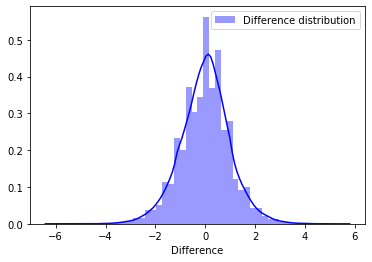

In [24]:
sns.distplot(example['Difference'], color = 'blue') 
plt.legend(labels=['Difference distribution'])
plt.show()

example of using min-max normalization:


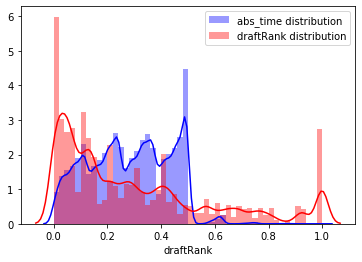

In [25]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

nonNormal_parameters = ['abs_min', 'draftRank']
example[nonNormal_parameters] = mm.fit_transform(example[nonNormal_parameters])
sns.distplot(example['abs_min'], color = 'blue', label = 'abs_min distribution') 
sns.distplot(example['draftRank'], color = 'red', label = 'draftRank distribution') 
plt.legend(labels=['abs_time distribution','draftRank distribution'])
plt.show()

## Baseline Model
Predicit free-throw success only with FT% feature. No learning process or algorithm is used here.
Threshold classificator, FT% over 0.5 will be predicted as 1, else 0.

In [35]:
## Baseline model
from sklearn import metrics

baseline_predict = db_for_baseline_model["FT%"].apply(lambda x: 1 if x>=0.6 else 0)
expected = database.shot_made
print(metrics.classification_report(expected, baseline_predict))

              precision    recall  f1-score   support

           0       0.45      0.11      0.18    128797
           1       0.78      0.96      0.86    413322

    accuracy                           0.76    542119
   macro avg       0.61      0.53      0.52    542119
weighted avg       0.70      0.76      0.70    542119



## Logisitic Regression
- Positions are transformed to numerical
- semiNormal features standarted to mean=0, std=1
- nonNormal_parameters rescaled to 0-1 range

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

# Pre-process for this model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank','First_shot',
                    'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters])
X_test[semiNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters])
X_train[nonNormal_parameters] = mm.fit_transform(X_train[nonNormal_parameters])
X_test[nonNormal_parameters] = mm.fit_transform(X_test[nonNormal_parameters])

# changing the position variable from categorial variable to numeric variable:
from preProcess import preProcess_position
X_train = preProcess_position(X_train)
X_test = preProcess_position(X_test)
## End pre-process

logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(X_train.values, y_train.values)
predictions = logreg.predict(X_test.values)
predicted_probs = logreg.predict_proba(X_test.values)

print(metrics.classification_report(y_test, predictions))

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.38      0.50      0.43    178900
weighted avg       0.58      0.76      0.66    178900



### Linear SVM Model
- Positions are transformed to numerical
- semiNormal features standarted to mean=0, std=1
- nonNormal_parameters rescaled to 0-1 range

In [37]:
# from sklearn.model_selection import train_test_split
# from sklearn import linear_model
# from sklearn import metrics

# # Pre-process for this model
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# mm = MinMaxScaler()
# sc = StandardScaler()
# semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
# nonNormal_parameters = ['abs_min', 'draftRank']

# X_train = X_raw_train.copy()
# X_test = X_raw_test.copy()

# X_train[semiNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters])
# X_test[semiNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters])
# X_train[nonNormal_parameters] = mm.fit_transform(X_train[nonNormal_parameters])
# X_test[nonNormal_parameters] = mm.fit_transform(X_test[nonNormal_parameters])

# # changing the position variable from categorial variable to numeric variable:
# from preProcess import preProcess_position
# X_train = preProcess_position(X_train)
# X_test = preProcess_position(X_test)
# ## End pre-process


# # Linear SVM Model
# from sklearn.svm import SVC
# linear_svm_model = SVC(kernel='linear', class_weight='balanced',verbose=True,C=1)
# linear_svm_model.fit(X_train.values, y_train.values)
# print("Training DONE!")
# predictions = linear_svm_model.predict(X_test.values)
# print(metrics.classification_report(y_test, predictions))

### Neural Net - binary_crossentropy LOSS
- Position feature one-hod encoded
- All features standarted to mean=0, std=1


In [38]:
from preProcess import detect_and_remove_outliers

# Pre-process for this model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
print(X_train.columns)
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])
## End pre-process

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import to_categorical
from keras.optimizers import Adagrad
from sklearn import metrics

model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(20))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(10))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(5))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss="binary_crossentropy", optimizer=Adagrad(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=256)
print("Metrics summary for training")
print(metrics.classification_report(y_train, np.round(model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

W0123 20:49:29.417329 30704 deprecation_wrapper.py:119] From C:\Users\guyazov\Anaconda2\envs\code_summarization_project\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0123 20:49:29.436279 30704 deprecation_wrapper.py:119] From C:\Users\guyazov\Anaconda2\envs\code_summarization_project\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0123 20:49:29.439272 30704 deprecation_wrapper.py:119] From C:\Users\guyazov\Anaconda2\envs\code_summarization_project\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0123 20:49:29.475175 30704 deprecation_wrapper.py:119] From C:\Users\guyazov\Anaconda2\envs\code_summarization_project\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placehold

Index(['playoffs', 'ShootingHand', 'FG%', '2P%', '3P%', 'FT%', 'Height',
       'Weight', 'draftRank', 'abs_min', 'Difference', 'Pos_C', 'Pos_PF',
       'Pos_PG', 'Pos_SF', 'Pos_SG'],
      dtype='object')


TypeError: Unexpected keyword argument passed to optimizer: learning_rate

#### We can see that because our dataset is not balanced, our models tend to predict '1' (shot made) most of the time, we have a problem. 
#### If we look at the recall parameter on label '0' (shot missed) we can see that we receive really bad perfomance on this metric.
#### We will try to attack this problem with some different methods.

## OverSampling try

One common way to tackle the issue of imbalanced data is over-sampling. Over-sampling refers to various methods that aim to increase the number of instances from the underrepresented class in the data set. In our case, these techniques will increase the number of fraudulent transactions in our data to 50:50 (instead of 25:75).

The easiest way to do so is to randomly select observations from the minority class and add them to the data set until we achieve a balance between the majority and minority class.

In [ ]:
from preProcess import detect_and_remove_outliers

# Pre-process for this model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
print(X_train.columns)
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])
## End pre-process
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import to_categorical
from keras.optimizers import Adagrad
from sklearn import metrics

model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(20))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(10))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(5))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))

from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

model.compile(loss="binary_crossentropy", optimizer=Adagrad(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=256)
print("Metrics summary for training")
print(metrics.classification_report(y_train, np.round(model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

##### We can see that this method helps us to achieve better recall metric on label '0', but we receive a -10% perfomance on accuracy.

## FocalLOSS try

focal loss down-weights the well-classified examples. This has the net effect of putting more training emphasis on that data that is hard to classify. In a practical setting where we have a data imbalance, our majority class will quickly become well-classified since we have much more data for it. Thus, in order to insure that we also achieve high accuracy on our minority class, we can use the focal loss to give those minority class examples more relative weight during training.
Paper: https://arxiv.org/abs/1708.02002

![title](img/focal_loss.png)

In [ ]:
from preProcess import detect_and_remove_outliers

# Pre-process for this model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])

X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

from keras import backend as K
import tensorflow as tf
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import to_categorical
from keras.optimizers import Adagrad
from sklearn import metrics

model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(20))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(10))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(5))#, activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=[focal_loss], optimizer=Adagrad(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_model_train, epochs=200, batch_size=256)
print("Metrics summary for training")
print(metrics.classification_report(y_model_train, np.round(model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

#### Also in this case, we get an improvement on our label '0' recall , but our accuracy performance is still lower comparing to the baseline model
#### Comparing against the model trained with overSampling we receive a lower perfomance on '0' recall metric, but a better accuracy.

In [ ]:
# from preProcess import run_PCA, find_correlations,detect_and_remove_outliers
# from models import logreg
# from sklearn.model_selection import train_test_split
# from sklearn import linear_model
# from sklearn import metrics

# v = model_database.player.value_counts()
# log_reg_database = model_database[model_database.player.isin(v.index[v.gt(200)])] ## leave only players with more than 200 games.
# Y = log_reg_database['shot_made']
# X = log_reg_database.drop(columns=['shot_made','player'])
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# number_of_components = 2
# X_train, X_test = run_PCA(X_train, X_test,number_of_components)

# print(logreg(X_train, Y_train,X_test, Y_test))



### xgboost regressor model with Shap visualizations

Series.base is deprecated and will be removed in a future version


[21:57:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Metrics summary for training


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     68063
           1       0.77      1.00      0.87    225646

    accuracy                           0.77    293709
   macro avg       0.38      0.50      0.43    293709
weighted avg       0.59      0.77      0.67    293709

Metrics summary for test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.38      0.50      0.43    178900
weighted avg       0.58      0.76      0.66    178900



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


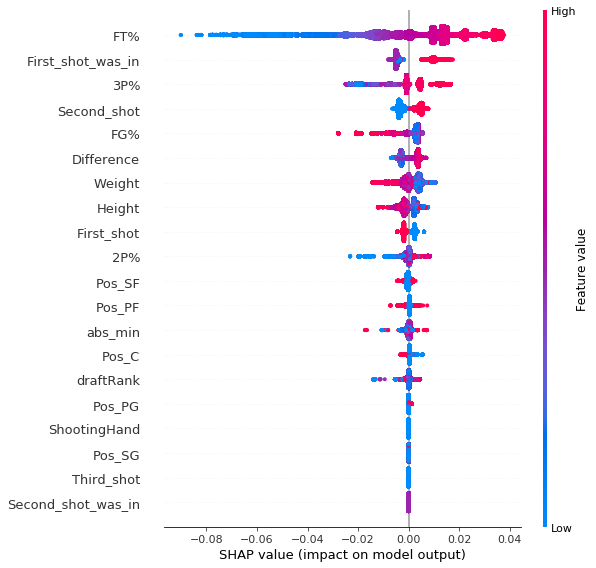

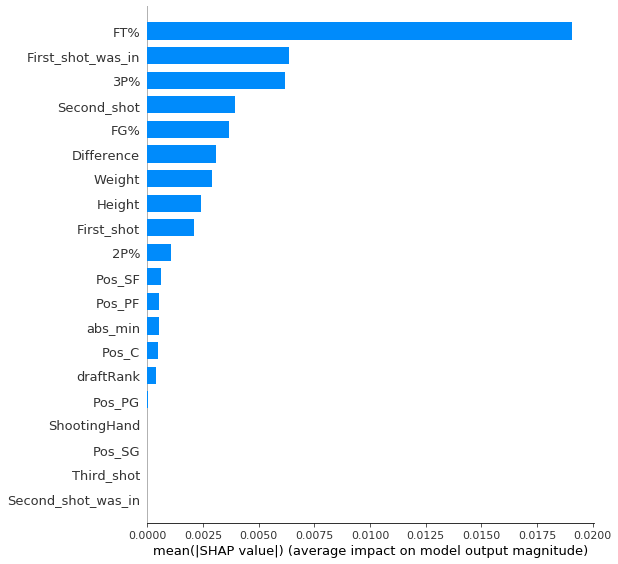

In [36]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from preProcess import detect_and_remove_outliers

# Pre-process for this model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank','First_shot',
                    'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])

X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

model = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 10)
model.fit(X_train,y_model_train)


print("Metrics summary for training")
print(metrics.classification_report(y_model_train, np.round(model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))


shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

##### So we understand now, our imbalanced dataset is a problem, and our tries to fix this unbalance results as lower accuracy performance.
##### We will try to train different models to understand which features are the dominant in the models

### Xgboost classifier model with Shap visualizations

Metrics summary for training
              precision    recall  f1-score   support

           0       0.66      0.00      0.01     68063
           1       0.77      1.00      0.87    225646

    accuracy                           0.77    293709
   macro avg       0.71      0.50      0.44    293709
weighted avg       0.74      0.77      0.67    293709

Metrics summary for test
              precision    recall  f1-score   support

           0       0.59      0.00      0.01     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.68      0.50      0.44    178900
weighted avg       0.72      0.76      0.66    178900



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


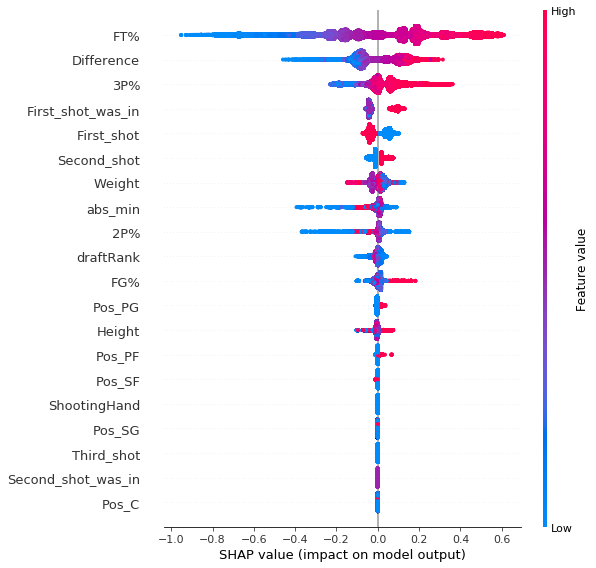

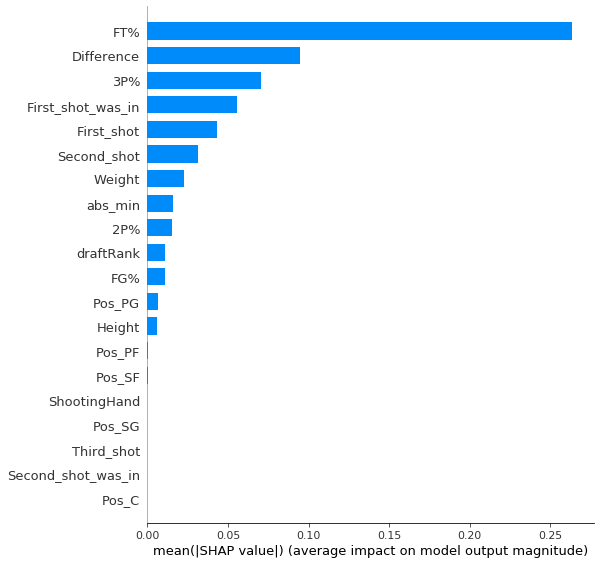

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


# Pre-process for this model
from preProcess import detect_and_remove_outliers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank','First_shot',
                    'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])

X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

model = XGBClassifier()
 
# fit the model with the training data
model.fit(X_train,y_model_train)

 
print("Metrics summary for training")
print(metrics.classification_report(y_model_train, np.round(model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

#### Xgboost classifier model with FocalLoss


In [ ]:
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# Pre-process for this model
from preProcess import detect_and_remove_outliers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])

X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}


xgboster_focal = imb_xgb(special_objective='focal')
CV_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[2.0]})
CV_focal_booster.fit(X_train.values, y_model_train.values)
opt_focal_booster = CV_focal_booster.best_estimator_

print("Metrics summary for training")
print(metrics.classification_report(y_model_train,opt_focal_booster.predict_determine(X_train.values)))

print("Metrics summary for test")
print(metrics.classification_report(y_test, opt_focal_booster.predict_determine(X_test.values)))


## Random Forest

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Pre-process for this model
from preProcess import detect_and_remove_outliers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank','First_shot',
                    'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])

X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

rf = RandomForestClassifier(n_estimators=16, max_depth=20, random_state=0)
rf.fit(X_train.values, y_model_train.values)


print("Metrics summary for training")
print(metrics.classification_report(y_model_train, np.round(rf.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(rf.predict(X_test))))

#shap.initjs()
#explainer = shap.TreeExplainer(rf)
#shap_values = explainer.shap_values(X_train)
#shap.summary_plot(shap_values, X_train)
#shap.summary_plot(shap_values, X_train, plot_type="bar")

Metrics summary for training
              precision    recall  f1-score   support

           0       0.97      0.38      0.54     68063
           1       0.84      1.00      0.91    225646

    accuracy                           0.85    293709
   macro avg       0.91      0.69      0.73    293709
weighted avg       0.87      0.85      0.83    293709

Metrics summary for test
              precision    recall  f1-score   support

           0       0.38      0.09      0.15     42604
           1       0.77      0.95      0.85    136296

    accuracy                           0.75    178900
   macro avg       0.58      0.52      0.50    178900
weighted avg       0.68      0.75      0.68    178900



###### Trying another threshold:

In [48]:
threshold = 0.655
predicted_train_proba = rf.predict_proba(X_train.values)
predicted_test_proba = rf.predict_proba(X_test.values)

predicted_train = (predicted_train_proba [:,1] >= threshold).astype('int')
predicted_test = (predicted_test_proba [:,1] >= threshold).astype('int')

print("Metrics summary for training")
print(metrics.classification_report(y_model_train, predicted_train))

print("Metrics summary for test")
print(metrics.classification_report(y_test, predicted_test))



Metrics summary for training
              precision    recall  f1-score   support

           0       0.83      0.70      0.76     68063
           1       0.91      0.96      0.94    225646

    accuracy                           0.90    293709
   macro avg       0.87      0.83      0.85    293709
weighted avg       0.89      0.90      0.89    293709

Metrics summary for test
              precision    recall  f1-score   support

           0       0.33      0.27      0.30     42604
           1       0.78      0.83      0.81    136296

    accuracy                           0.70    178900
   macro avg       0.56      0.55      0.55    178900
weighted avg       0.68      0.70      0.68    178900



In [41]:
from sklearn.metrics import accuracy_score, recall_score
recall_score_train_max = 0
recall_score_test_max = 0
threshold_train_max = 0
threshold_test_max = 0
thresholds = np.arange(0.6,1,0.01)
for threshold in thresholds:
    predicted_train_proba = rf.predict_proba(X_train.values)
    predicted_test_proba = rf.predict_proba(X_test.values)
    predicted_train = (predicted_train_proba [:,1] >= threshold).astype('int')
    predicted_test = (predicted_test_proba [:,1] >= threshold).astype('int')
    if recall_score_train_max < recall_score(y_model_train, predicted_train, pos_label=0) and accuracy_score(y_model_train, predicted_train) > 0.7:
        recall_score_train_max = recall_score(y_model_train, predicted_train, pos_label=0)
        threshold_train_max = threshold 
    if recall_score_test_max < recall_score(y_test, predicted_test, pos_label=0) and accuracy_score(y_test, predicted_test) > 0.7:
        recall_score_test_max = recall_score(y_test, predicted_test, pos_label=0)
        threshold_test_max = threshold 
print("threshold train max:",threshold_train_max, "recall_train_max : ", recall_score_train_max)
print("threshold test max:",threshold_test_max, "recall_test_max : ", recall_score_test_max)

    #print("Metrics summary for training")
    #print(metrics.classification_report(y_model_train, predicted_train))
    #print("Metrics summary for test")
    #print(metrics.classification_report(y_test, predicted_test))

threshold train max: 0.8200000000000002 recall_train_max :  0.9753757548153916
threshold test max: 0.64 recall_test_max :  0.24467186179701436


#### K-Nearset Neighbours

In [ ]:
# Pre-process for this model
from preProcess import detect_and_remove_outliers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
sc = StandardScaler()
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters+nonNormal_parameters])
X_test[semiNormal_parameters+nonNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters+nonNormal_parameters])

onehot_pos_col = pd.get_dummies(X_train['Pos'],prefix='Pos')
X_train = pd.concat([X_train,onehot_pos_col],axis=1)
X_train = X_train.drop(columns=['Pos'])
onehot_pos_col = pd.get_dummies(X_test['Pos'],prefix='Pos')
X_test = pd.concat([X_test,onehot_pos_col],axis=1)
X_test = X_test.drop(columns=['Pos'])

X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski',p=2)
knn.fit(X_train, y_model_train)

print("Metrics summary for training")
print(metrics.classification_report(y_model_train, knn.predict(X_train)))

print("Metrics summary for test")
print(metrics.classification_report(y_test, knn.predict(X_test)))


Plotting pairwise distributions

In [ ]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(xgboost_dataset.iloc[:,0:10], figsize=(15,11))